# Recurrent Neural Network - LSTM


## Part 1 - Data Preprocessing

---



### Import the libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import math
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error

from keras.layers.core import Dense
from keras.layers.recurrent import LSTM
from keras.layers import  Dropout
from keras import regularizers

import keras.backend as K

import seaborn as sns
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from keras.layers import *


import sys, time, random, json, pickle, itertools
import networkx as nx
import matplotlib
import scipy.stats
from sklearn.neighbors import KernelDensity
import statsmodels.stats.correlation_tools as stm

import torch, torchvision
from sklearn.preprocessing import MinMaxScaler
np.random.seed(12345678)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Import the database

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

import os
workdir_path = '/content/drive/MyDrive/Summer 2022 RA'
os.chdir(workdir_path)

Mounted at /content/drive


In [ ]:
# Define data files
datadir = 'dataverse_files/'
datafn_tmpl = datadir + 'sms-call-internet-mi-%4d-%02d-%02d.txt'
datafn_idxs = [ (2013, 11, i) for i in range(1,5) ]  #+ [ (2013, 12, i) for i in range(1, 32) ] + [ (2014, 1, 1) ]
datafns = [ datafn_tmpl % x for x in datafn_idxs ]
print("Number of non-existent files:", sum([ not os.path.exists(fn) for fn in datafns ]))
outfn = datadir[:-1] + '-internet.csv'

# dataset_train = pd.read_csv('train.csv')
# training_set = dataset_train.iloc[:, 1:2].values #only column of the series itself

Number of non-existent files: 0


In [ ]:
# Pick the data files to index
fns = datafns#[:10]

### Read and Preprocess Data (Save to CSV)

In [ ]:
data = pd.DataFrame()
for fn in fns:
    #print('Reading file ', fn, ' ...')
    df = pd.read_csv(fn, sep="\t", header=None, names=['grid', 'time', 'country', 'sms-in', 'sms-out', 'call-in', 'call-out', 'internet'])
    df = df[ df['country'] == 39 ].drop(columns=['country', 'sms-in', 'sms-out', 'call-in', 'call-out']).fillna(0)
    data = pd.concat([ data, df ])
data = data.sort_values(by=['time', 'grid']).reset_index(drop=True)

In [ ]:
# Statistics of the dataset
print("# 10min slots:", len(data['time'].unique()) )
print("Mean internet:", data['internet'].mean())
print("(Min, 5%, 25%, median, 75%, 95%, max) internet:")
print( ( data['internet'].min(), data['internet'].quantile(0.05), data['internet'].quantile(0.25), data['internet'].median(), data['internet'].quantile(0.75), data['internet'].quantile(0.95), data['internet'].max() )  )

# 10min slots: 576
Mean internet: 61.471731830811194
(Min, 5%, 25%, median, 75%, 95%, max) internet:
(0.0, 2.969617072813118, 10.982975646323265, 27.925311205624425, 65.51675429623229, 235.37264641289994, 7936.265379884158)


In [ ]:
data.to_csv(outfn)

### Load Data

In [ ]:
data = pd.read_csv(outfn, index_col=0)
print("# 10min slots:", len(data['time'].unique()) )

# 10min slots: 576


In [ ]:
# Find a grid with the maximum total demand for the prediction task
max_dmd_grid = sorted([ ( data[ data['grid']==i ]['internet'].sum(), i ) for i in range(1, 10001) ])
max_dmd_grid = list(reversed(max_dmd_grid))
gridx = max_dmd_grid[0][1]
#max_dmd_grid[:30]

In [ ]:
datax = data[ data['grid'] == gridx ].reset_index(drop=True)

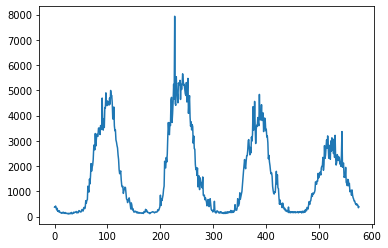

In [ ]:
# Plot the data
datax['internet'].plot()

### Learning and Prediction

### Preparing data

In [ ]:
# Parameters
total_size = len(datax.index)
train_size = int(total_size * 2 / 3)
test_size = total_size - train_size
print("Train size:", train_size, "Test size:", test_size)

Train size: 384 Test size: 192


In [ ]:
# Train/test split
#x = datax['internet'].to_numpy()

train = datax[:train_size]
test = datax[train_size:]
dataset_train = train
training_set = dataset_train.iloc[:, 2:3].values

### Time Series Graph

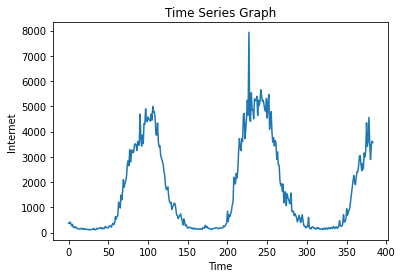

In [ ]:
plt.plot(training_set)
plt.xlabel("Time")
plt.ylabel("Internet")
plt.title("Time Series Graph")
plt.show()

# plt.plot(datax['internet'])
# plt.xlabel("Time")
# plt.ylabel("Internet")
# plt.title("Time Series Graph")
# plt.show()

### Normalization



In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

### Create the data structure with window 15 and output 1

In [ ]:
window = 144
trainSize = len(training_set_scaled)
X_train = []
y_train = []
for i in range(window, trainSize):
    X_train.append(training_set_scaled[i-window:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

### Reshaping

In [ ]:
X_train.shape

(240, 144)

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [ ]:
X_train.shape

(240, 144, 1)

## Part 2 - Construction of the RNN

### Construction of the complete network

In [ ]:
# Initialize the RNN
regressor = Sequential()

# Add the first LSTM layer and Dropout
regressor.add(LSTM (  len(train) , activation = 'tanh', input_shape =(X_train.shape[1], 1),kernel_regularizer=regularizers.l1_l2(l1=0.0,l2=0.0) ))
regressor.add(Dropout(0.2))
regressor.add (Dense (units = 1, activation = 'linear'))


# Compile the network
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Summarize the network
regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 384)               592896    
                                                                 
 dropout (Dropout)           (None, 384)               0         
                                                                 
 dense (Dense)               (None, 1)                 385       
                                                                 
Total params: 593,281
Trainable params: 593,281
Non-trainable params: 0
_________________________________________________________________


### Training

In [ ]:
regressor.fit(X_train, y_train, epochs = 150, batch_size = 128)

Epoch 1/150
2/2 [==============================] - 6s 2s/step - loss: 0.0613
Epoch 2/150
2/2 [==============================] - 4s 2s/step - loss: 0.0130
Epoch 3/150
2/2 [==============================] - 4s 2s/step - loss: 0.0076
Epoch 4/150
2/2 [==============================] - 4s 2s/step - loss: 0.0079
Epoch 5/150
2/2 [==============================] - 3s 2s/step - loss: 0.0066
Epoch 6/150
2/2 [==============================] - 3s 2s/step - loss: 0.0040
Epoch 7/150
2/2 [==============================] - 3s 2s/step - loss: 0.0054
Epoch 8/150
2/2 [==============================] - 3s 2s/step - loss: 0.0033
Epoch 9/150
2/2 [==============================] - 4s 2s/step - loss: 0.0033
Epoch 10/150
2/2 [==============================] - 4s 2s/step - loss: 0.0038
Epoch 11/150
2/2 [==============================] - 4s 2s/step - loss: 0.0030
Epoch 12/150
2/2 [==============================] - 5s 2s/step - loss: 0.0031
Epoch 13/150
2/2 [==============================] - 4s 2s/step - loss: 0.

## Part 3 - Making predictions and analyzing the results

### Test base

In [ ]:
dataset_test = test
test_pul = dataset_test.iloc[:, 2:3].values

### Build the framework for testing

In [ ]:
dataset_total = pd.concat((dataset_train.iloc[:,2], dataset_test.iloc[:,2]), axis = 0)

testLength = len(dataset_test)
inputs = dataset_total[len(dataset_total) - testLength - window:].values
inputs = inputs.reshape(inputs.shape[0],1)

inputs = sc.transform(inputs)
X_test = []
for i in range(window, inputs.shape[0]):
    X_test.append(inputs[i-window:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Make the predictions


In [ ]:
predicted = regressor.predict(X_test)
regressor.save_weights('weightsfile_lstm.h5')
#existingModel.load_weights('weightsfile.h5')
predicted = sc.inverse_transform(predicted)

In [ ]:
# print(len(predictions))
# print(predictions.shape)

In [ ]:
# x = np.arange(test_size)

### Visualization of training and test results

In [ ]:
# plt.title('Time slot vs mobile traffic')
# plt.ylabel('Internet traffic')
# plt.grid(True)
# plt.autoscale(axis='x', tight=True)
# plt.plot(test)
# plt.plot(x,predictions)
# plt.show()

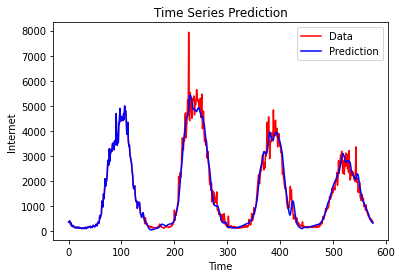

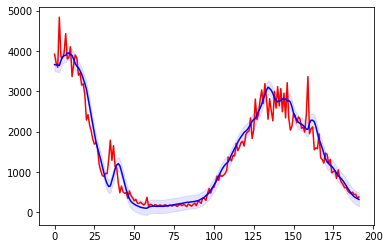

In [ ]:
allTargetData = np.vstack((training_set, test_pul))
training_predicted = regressor.predict(X_train)
training_predicted = sc.inverse_transform(training_predicted)
allForecastedData = np.vstack((training_set[0:window], training_predicted, predicted))
plt.plot(allTargetData, color = 'red', label = 'Data')
plt.plot(allForecastedData, color = 'blue', label = 'Prediction')
plt.xlabel("Time")
plt.ylabel("Internet")
plt.title("Time Series Prediction")
plt.legend()
plt.savefig('predictions_training_test.svg')
plt.show()

from matplotlib import pyplot as plt
import numpy as np

#some example data
x = np.arange(test_size)
# plt.title('Time slot vs mobile traffic')
# plt.ylabel('Internet traffic')
# plt.grid(True)
# plt.autoscale(axis='x', tight=True)
# plt.plot(test)
# plt.plot(x,predictions)
# plt.show()
y = predicted.reshape(-1,)
#some confidence interval
ci = 1.96 * np.std(predicted)/np.sqrt(len(x))

fig, ax = plt.subplots()
ax.plot(x,test_pul.reshape(-1,),'r')
ax.plot(x,y, 'b')
ax.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)

## Part 4 - Evaluation Metrics


In [ ]:
rmse = math.sqrt(mean_squared_error(test_pul, predicted))
print('RMSE: ', rmse)

RMSE:  288.41399925845394


In [ ]:
mse = mean_squared_error(test_pul, predicted)
print('MSE: ',mse)

MSE:  83182.63496825546


In [ ]:
mape = np.mean(np.abs((test_pul - predicted) / test_pul)) * 100
print('MAPE: ',mape, '%')

MAPE:  18.228370221030453 %


In [ ]:
mae = mean_absolute_error(test_pul, predicted)
print('MAE: ',mae)

MAE:  191.78480603280082


### Statistics of the test results.

In [ ]:
# Fraction of under-estimated demands
violated = (predicted < test_pul)
violations = (test_pul - predicted)[violated]
print('Total violations:', sum(violated), '(%.2f%% of the test data points)' % (100*sum(violated)/test_size) )

Total violations: [75] (39.06% of the test data points)


In [ ]:
print('Demand mean:', np.mean(test_pul))
print('Violation mean:', np.mean( violations ) )
print('Violation excess: %.2f%%' % (100 * np.mean( violations ) / np.mean(test_pul)) )

Demand mean: 1460.177548950116
Violation mean: 193.32225352608262
Violation excess: 13.24%
